In [1]:
import os
import sys
sys.path.append('/scratch/users/k21066795/prj_normal/RandStainNA')
from randstainna import RandStainNA

import glob
import h5py
import random
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from randstainna import RandStainNA

import cv2
from utils_data import add_ageGroup
from utils_features import ensemble_feas_labels, labelingFeature, CSVDataset_WSI, get_model, extract_features, sampeled_UMP
from utils import plot_multiple, plot_oneline


def ROIs_per_mm2(wsiname, WSIs, WSI_QC, rootdir):
    '''
    given a wsi, calculate the tissue area, number of ROIs detected per mm^2, and percentage of epithelium/tissue area (%)
    '''
    folder = os.path.join(WSI_QC, wsiname+'.ndpi')
    mask_pt = [i for i in os.listdir(folder) if '_mask_use.npy' in i]
    mask_pt = os.path.join(WSI_QC, wsiname+'.ndpi', mask_pt[0])
    mask = np.load(mask_pt)
    
    wsi_pt = os.path.join(WSIs, wsiname+".ndpi")
    wsi = openslide.OpenSlide(wsi_pt)
    scale_factor = wsi.level_dimensions[0][1] // mask.shape[0]
    print(f'scale_factor: {scale_factor}')
    mpp = wsi.properties['openslide.mpp-y'] # um/pixel
    wsi_area = np.sum(mask) * scale_factor * scale_factor * float(mpp)*0.001 * float(mpp) * 0.001 # mm^2
    
    print(f'wsi_area: {wsi_area}')

    csv_folder = os.path.join(rootdir, wsiname)
    csv_pt = glob.glob(f"{csv_folder}/*_patch_merge.csv")[0]
    csv_df = pd.read_csv(csv_pt)
    patient_age = np.unique(csv_df['age'])[0]
    patient_id = np.unique(csv_df['patient_id'])[0]
    wsi_id = np.unique(csv_df['wsi_id'])[0]
    
    print(f'patient_age: {patient_age}')

    ROI_num = len(np.unique(csv_df['roi_id']))
    ROI_adjust = np.around(ROI_num/wsi_area, 3)
    print(f'ROI_count_adjust: {ROI_adjust} lobules per mm^2')
    

    epi_num = np.sum(csv_df['cls']=='epithelium')
    epi_area_mm2 = epi_num * 128 * 128 *0.001 *0.001
    epi_percent = np.around(epi_area_mm2/wsi_area, 3) # percentage of epithelium on the slide
    
    print(f'epi_count_adjust: {epi_adjust} epithelium patches per mm^2')
      
    return patient_id, wsi_id, ROI_adjust, epi_percent, patient_age


/scratch/users/k21066795/conda/torch_env/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/scratch/users/k21066795/conda/torch_env/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


#--------------------------check lobule types----------------------------#

In [2]:
# visualise lobule types on WSIs
import cv2
import json
import openslide


def generate_mask(wsi_path, anno_pt, scale_factor):
    slide=openslide.OpenSlide(wsi_path)
    with open(anno_pt, "r") as f:
        shapes = json.load(f)
    
    # level = slide.level_count - 1
    # scale_factor = 1/slide.level_downsamples[level]
    # width, height = slide.level_dimensions[level]

    width, height = slide.level_dimensions[0]
    width, height = int(width * scale_factor), int(height * scale_factor)
    
    background = np.zeros((height, width, 3), np.uint8)
    mask = np.full((height, width, 3), background, dtype=np.uint8)
    
    for shape in shapes["features"]:
        points = shape["geometry"]["coordinates"][0]
        points = np.array([(p[0], p[1]) for p in points])
        points = points * scale_factor
        points = points.astype(int)
    
        cls = shape["properties"]["classification"]["name"]
        if cls == "3":
          color = (255, 0, 0)
          mask = cv2.drawContours(mask, [points], -1, color=color, thickness=-1)
          mask = cv2.fillPoly(mask, [points], color=color)
        elif cls == "2":
          color = (0, 255, 0)
          mask = cv2.drawContours(mask, [points], -1, color=color, thickness=-1)
          mask = cv2.fillPoly(mask, [points], color=color)
        elif cls == "1":
          color = (0, 0, 255)
          mask = cv2.drawContours(mask, [points], -1, color=color, thickness=-1)
          mask = cv2.fillPoly(mask, [points], color=color)
        
    return mask



def get_lobule_patches(mask_im, patch_ids):
    type1 = []
    type2 = []
    type3 = []
    for patch_id in patch_ids:
        grid_x, grid_y = patch_id.split("_")[-3], patch_id.split("_")[-2]
        grid_x, grid_y = int(grid_x), int(grid_y)
        value = tuple(mask_im[grid_y, grid_x, :])
        if value == (255, 0, 0):
            lobule = 'type3'
            type3.append(patch_id)
            
        elif value == (0, 255, 0):
            lobule = 'type2'
            type2.append(patch_id)
        
        elif value == (0, 0, 255):
            lobule = 'type1'
            type1.append(patch_id)
    return type1, type2, type3


def parse_patch_id(patch_id):
    wsiname = "_".join(patch_id.split("_")[:3])
    ROI_id = "_".join(patch_id.split("_")[4:8])
    gridx, gridy, patch_size = patch_id.split("_")[-3:]
    gridx, gridy, patch_size = int(gridx), int(gridy), int(patch_size)
    
    return wsiname, ROI_id, gridx, gridy, patch_size


In [3]:
# get wsi_ids
annoDir = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule'
wsi_ids = [i.split('.geojson')[0] for i in os.listdir(annoDir)]
wsi_pts = [glob.glob(f"/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/{wsiname}*.*")[0] for wsiname in wsi_ids]
wsi_pts.sort()
wsi_pts

['/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17063106_FPE_3.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17063107_FPE_4.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17063396_FPE_5.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17063451_FPE_3.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17063504_FPE_6.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17063838_FPE_2.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17063839_FPE_3.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17063968_FPE_3.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17064108_FPE_1.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17064113_FPE_4.ndpi',
 '/scratch/prj/cb_normalbreast/Siyuan/pr

In [4]:
# get annotations
anno_pts = [os.path.join(annoDir, i) for i in os.listdir(annoDir)]
anno_pts.sort()
anno_pts

['/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17063106_FPE_3.geojson',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17063107_FPE_4.geojson',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17063396_FPE_5.geojson',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17063451_FPE_3.geojson',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17063504_FPE_6.geojson',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17063838_FPE_2.geojson',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17063839_FPE_3.geojson',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17063968_FPE_3.geojson',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17064108_FPE_1.geojson',
 '/scratch

In [5]:
# get patch ids
csvDir = "/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/"
wsi_ids = [i.split('.geojson')[0] for i in os.listdir(annoDir)]
csv_pts = [f"{csvDir}{wsi_id}/{wsi_id}_patch_merge.csv" for wsi_id in wsi_ids]
csv_pts.sort()
csv_pts

['/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17063106_FPE_3/17063106_FPE_3_patch_merge.csv',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17063107_FPE_4/17063107_FPE_4_patch_merge.csv',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17063396_FPE_5/17063396_FPE_5_patch_merge.csv',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17063451_FPE_3/17063451_FPE_3_patch_merge.csv',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17063504_FPE_6/17063504_FPE_6_patch_merge.csv',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17063838_FPE_2/17063838_FPE_2_patch_merge.csv',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17063839_FPE_3/17063839_FPE_3_patch_merge.csv',
 '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17063968_FPE_3/17063968_FPE_3_patch_merge.csv',


In [29]:
# select one WSI for demonstration
for index in range(16):
    wsi_path = wsi_pts[index]
    anno_pt = anno_pts[index]
    csv_pt = csv_pts[index]
    print(index)
    # print(wsi_path)
    # print(anno_pt)
    # print(csv_pt)
    try:
        df = pd.read_csv(csv_pt)
        print(f"patient age: {np.unique(df['age'])}")
    
        patch_id = df['patch_id'][0]
        wsiname, ROI_id, gridx, gridy, patch_size = parse_patch_id(patch_id)
        # print(patch_size)
    except:
        continue

0
1
2
3
4
patient age: [62]
5
patient age: [37]
6
patient age: [37]
7
patient age: [45]
8
patient age: [29]
9
patient age: [38]
10
patient age: [47]
11
patient age: [47]
12
patient age: [30]
13
patient age: [23]
14
patient age: [22]
15
patient age: [41]


/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17063504_FPE_6.ndpi
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/17063504_FPE_6.geojson
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17063504_FPE_6/17063504_FPE_6_patch_merge.csv
patient age: [62]
579
scale_factor: 0.0017271157167530224
type1: 103 type2: 85 type3: 0
percentage: type1: 0.548 type2: 0.452 type3: 0.0


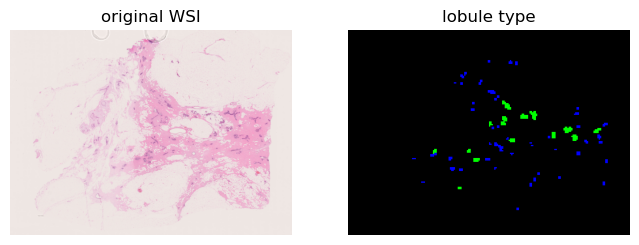

In [33]:
index = 4 
wsi_path = wsi_pts[index]
anno_pt = anno_pts[index]
csv_pt = csv_pts[index]
print(wsi_path)
print(anno_pt)
print(csv_pt)

df = pd.read_csv(csv_pt)
print(f"patient age: {np.unique(df['age'])}")
patch_id = df['patch_id'][0]
wsiname, ROI_id, gridx, gridy, patch_size = parse_patch_id(patch_id)
print(patch_size)

wsi=openslide.OpenSlide(wsi_path)
img = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
scale_factor = 1 / float(patch_size)
print(f"scale_factor: {scale_factor}")
mask_im = generate_mask(wsi_path, anno_pt, scale_factor)
plot_oneline(img_list=[img, mask_im], caption_list=['original WSI', 'lobule type'], 
             figure_size=(8,8), save_pt=None) # blue: type1; green: type2; red: type3

patch_ids = [i for i in df['patch_id']]
type1, type2, type3 = get_lobule_patches(mask_im, patch_ids)
print(f"type1: {len(type1)} type2: {len(type2)} type3: {len(type3)}")

together = len(type1) + len(type2) + len(type3)
print(f"percentage: type1: {np.around(len(type1)/together, 3)} type2: {np.around(len(type2)/together, 3)} type3: {np.around(len(type3)/together, 3)}")


/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/19001626_FPE_3.ndpi
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/19001626_FPE_3.geojson
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/19001626_FPE_3/19001626_FPE_3_patch_merge.csv
patient age: [22]
579
scale_factor: 0.0017271157167530224
type1: 302 type2: 2643 type3: 2339
percentage: type1: 0.057 type2: 0.5 type3: 0.443


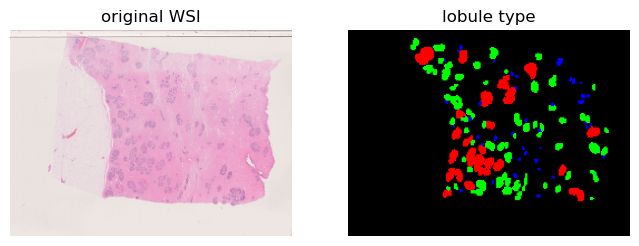

In [34]:
index = 14 
wsi_path = wsi_pts[index]
anno_pt = anno_pts[index]
csv_pt = csv_pts[index]
print(wsi_path)
print(anno_pt)
print(csv_pt)

df = pd.read_csv(csv_pt)
print(f"patient age: {np.unique(df['age'])}")
patch_id = df['patch_id'][0]
wsiname, ROI_id, gridx, gridy, patch_size = parse_patch_id(patch_id)
print(patch_size)

wsi=openslide.OpenSlide(wsi_path)
img = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
scale_factor = 1 / float(patch_size)
print(f"scale_factor: {scale_factor}")
mask_im = generate_mask(wsi_path, anno_pt, scale_factor)
plot_oneline(img_list=[img, mask_im], caption_list=['original WSI', 'lobule type'], 
             figure_size=(8,8), save_pt=None) # blue: type1; green: type2; red: type3

patch_ids = [i for i in df['patch_id']]
type1, type2, type3 = get_lobule_patches(mask_im, patch_ids)
print(f"type1: {len(type1)} type2: {len(type2)} type3: {len(type3)}")

together = len(type1) + len(type2) + len(type3)
print(f"percentage: type1: {np.around(len(type1)/together, 3)} type2: {np.around(len(type2)/together, 3)} type3: {np.around(len(type3)/together, 3)}")


/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/19004666_FPE_7.ndpi
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP_lobule/19004666_FPE_7.geojson
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/19004666_FPE_7/19004666_FPE_7_patch_merge.csv
patient age: [41]
555
scale_factor: 0.0018018018018018018
type1: 340 type2: 2441 type3: 943
percentage: type1: 0.091 type2: 0.655 type3: 0.253


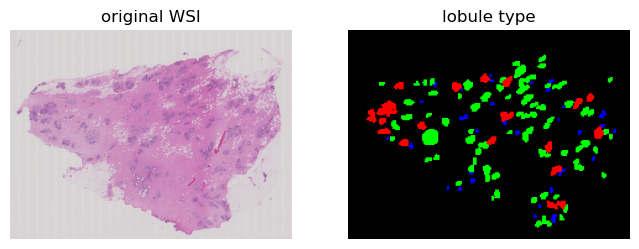

In [39]:
index = 15 # 13, 14, 8
wsi_path = wsi_pts[index]
anno_pt = anno_pts[index]
csv_pt = csv_pts[index]
print(wsi_path)
print(anno_pt)
print(csv_pt)

df = pd.read_csv(csv_pt)
print(f"patient age: {np.unique(df['age'])}")
patch_id = df['patch_id'][0]
wsiname, ROI_id, gridx, gridy, patch_size = parse_patch_id(patch_id)
print(patch_size)

wsi=openslide.OpenSlide(wsi_path)
img = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
scale_factor = 1 / float(patch_size)
print(f"scale_factor: {scale_factor}")
mask_im = generate_mask(wsi_path, anno_pt, scale_factor)
plot_oneline(img_list=[img, mask_im], caption_list=['original WSI', 'lobule type'], 
             figure_size=(8,8), save_pt=None) # blue: type1; green: type2; red: type3

patch_ids = [i for i in df['patch_id']]
type1, type2, type3 = get_lobule_patches(mask_im, patch_ids)
print(f"type1: {len(type1)} type2: {len(type2)} type3: {len(type3)}")

together = len(type1) + len(type2) + len(type3)
print(f"percentage: type1: {np.around(len(type1)/together, 3)} type2: {np.around(len(type2)/together, 3)} type3: {np.around(len(type3)/together, 3)}")


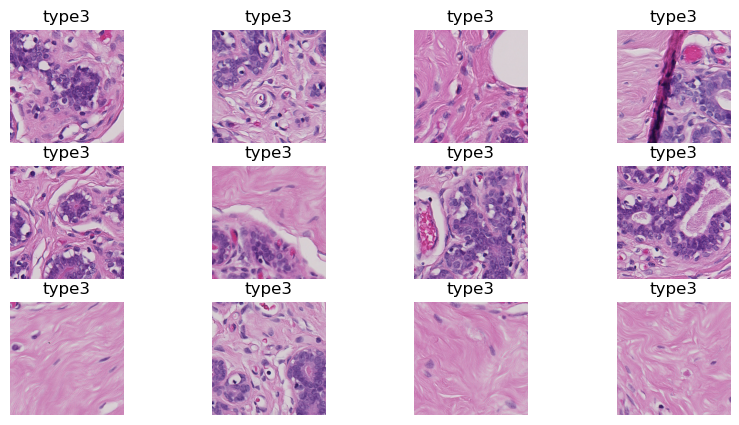

In [40]:
index = random.sample(range(0, len(type3)), 12)
imgs = []
for i in index:
    patch_id = type3[i]
    wsiname, ROI_id, gridx, gridy, patch_size = parse_patch_id(patch_id)
    im = wsi.read_region((int(gridx*patch_size), int(gridy*patch_size)), 0, (patch_size, patch_size)).convert('RGB')
    imgs.append(im)

plot_multiple(imgs, ['type3']*12, 3,4, (10,5), 'tab20')

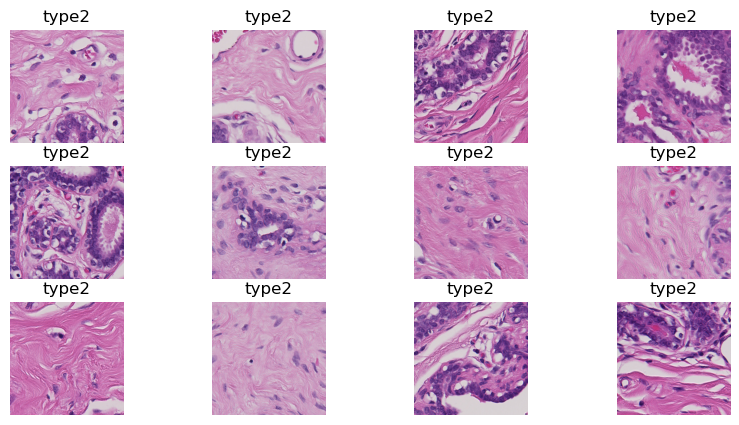

In [41]:
index = random.sample(range(0, len(type2)), 12)
imgs = []
for i in index:
    patch_id = type2[i]
    wsiname, ROI_id, gridx, gridy, patch_size = parse_patch_id(patch_id)
    im = wsi.read_region((int(gridx*patch_size), int(gridy*patch_size)), 0, (patch_size, patch_size)).convert('RGB')
    imgs.append(im)

plot_multiple(imgs, ['type2']*12, 3,4, (10, 5), 'tab20')

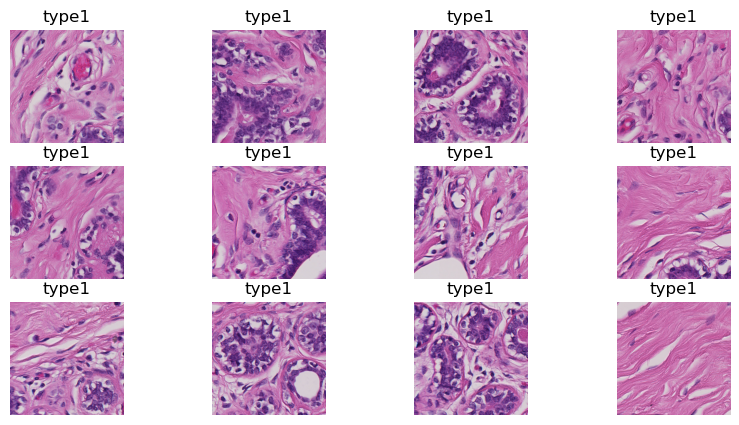

In [42]:
index = random.sample(range(0, len(type1)), 12)
imgs = []
for i in index:
    patch_id = type2[i]
    wsiname, ROI_id, gridx, gridy, patch_size = parse_patch_id(patch_id)
    im = wsi.read_region((int(gridx*patch_size), int(gridy*patch_size)), 0, (patch_size, patch_size)).convert('RGB')
    imgs.append(im)

plot_multiple(imgs, ['type1']*12, 3,4, (10, 5), 'tab20')

In [ ]:
## nuclei segmentation ????